In [2]:
import habitat
from env import Env
from utils import draw_top_down_map, AgentPosition

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import mrcnn.model as modellib

Using TensorFlow backend.


In [5]:
import coco
from PIL import Image
from mrcnn import utils
from mrcnn import visualize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import numpy as np

In [6]:
config = habitat.get_config("/data_config/challenge_objectnav2020.local.rgbd.yaml")

In [7]:
config.defrost()

H = 320
W = 640

config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W

config.PYROBOT.RGB_SENSOR.HEIGHT = H
config.PYROBOT.RGB_SENSOR.WIDTH = W
config.PYROBOT.DEPTH_SENSOR.HEIGHT = H
config.PYROBOT.DEPTH_SENSOR.WIDTH = W

config.DATASET.DATA_PATH = '/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'
config.DATASET.SCENES_DIR = '/data/scene_datasets'
config.DATASET.SPLIT = 'val_mini'

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.freeze()

In [8]:
env = Env(config)

2020-07-22 14:26:21,812 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1
2020-07-22 14:26:22,170 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-22 14:26:30,887 Initializing task ObjectNav-v1
Initializing task ObjectNav-v1


In [9]:
mapper = [1, 40, 1, 16, 4, 2, 4, 39, 4, 1, 17, 0, 1, 1, 40, 4, 1, 1, 14, 4, 24, 1, 0, 1, -1, 39, 17, 4, 5, 1, 1, 39, 21, 1, 2, 1, 15, 39, 40, 1, 1, 4, 1, 7, 28, 39, 40, 28, 40, 40, 39, 40, 39, 39, 39, 39, 39, 2, 17, 1, 40, 1, 1, 5, 1, 34, 15, 1, 15, 1, 20, 1, 15, 1, 15, 20, 20, 39, 4, 39, 39, 39, 39, 39, 28, 28, 28, 40, 1, 12, 9, 1, 0, 4, 4, 40, 23, 17, 2, 1, 1, 4, 23, 39, 2, 17, 40, 40, 34, 1, 34, 1, 1, 9, 1, 28, 9, 4, 28, 39, 28, 40, 2, 28, 28, 38, 4, 4, 0, 11, 1, 17, 1, 1, 7, 0, 15, 40, 0, 21, 1, 7, 4, 0, 28, 4, 1, 4, 39, 2, 39, 39, 20, 39, 39, 39, 39, 39, 39, 23, 2, 1, 1, 1, 4, 23, 4, 17, 1, 24, 40, 1, 1, 24, 1, 4, 17, 14, 4, 4, 4, 1, 14, 28, 4, 4, 14, 35, 39, 28, 28, 28, 39, 2, 28, 16, 2, 39, 2, 1, 37, 7, 40, 31, 1, 17, 1, 4, 1, 26, 4, 1, 1, 4, 7, 4, 20, 1, 20, 22, 40, 40, 3, 40, 3, 3, 16, 5, 39, 5, 20, 39, 3, 3, 3, 3, 3, 20, 20, 17, 4, 1, 2, 1, 40, 38, 4, 1, 17, 1, 1, 40, 2, 17, 40, 1, 17, 9, 9, 1, 39, 16, 9, 9, 40, 40, 40, 4, 1, 17, 40, 26, 1, 2, 16, 1, 39]
index_to_title_map = {17: 'ceiling', 9: 'window', 8: 'cushion', 11: 'bed', 1: 'wall', 2: 'floor', 31: 'shelving', 4: 'door', 39: 'objects', 22: 'tv_monitor', 13: 'chest_of_drawers', 3: 'chair', 40: 'misc', 34: 'seating', 6: 'picture', 35: 'board_panel', 26: 'counter', 23: 'shower', 18: 'toilet', 21: 'mirror', 7: 'cabinet', 0: 'void', 28: 'lighting', 15: 'sink', 5: 'table', 12: 'curtain', 20: 'towel', 25: 'bathtub', 19: 'stool', 16: 'stairs', 38: 'clothes', -1: 'nope', 37: 'appliances', 27: 'fireplace', 29: 'beam', 10: 'sofa', 14: 'plant'}

In [10]:
num_classes = len(list(index_to_title_map.keys()))

In [11]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # Give the configuration a recognizable name
    NAME = "habitat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = num_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 64, 128, 256, 320)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                49
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [12]:
COCO_MODEL_PATH = "/root/mask-r-cnn/mask_r_cnn_trained_v1.h5"
MODEL_DIR = "/root/mask-r-cnn/logs"

In [13]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [14]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = [index_to_title_map[i] for i in sorted(list(index_to_title_map.keys()))]
class_names

['nope',
 'void',
 'wall',
 'floor',
 'chair',
 'door',
 'table',
 'picture',
 'cabinet',
 'cushion',
 'window',
 'sofa',
 'bed',
 'curtain',
 'chest_of_drawers',
 'plant',
 'sink',
 'stairs',
 'ceiling',
 'toilet',
 'stool',
 'towel',
 'mirror',
 'tv_monitor',
 'shower',
 'bathtub',
 'counter',
 'fireplace',
 'lighting',
 'beam',
 'shelving',
 'seating',
 'board_panel',
 'appliances',
 'clothes',
 'objects',
 'misc']

In [15]:
def prepare_semantic_observation(observations):
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

    return np.take(mapping, observations['semantic'])

In [16]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [17]:
def plot_colortable(colors, title, sort_colors=True, emptycols=0):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left")

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)
        
    plt.show()

In [18]:
colors = list(mcolors.CSS4_COLORS.values())

new_colors = []

for index in np.round(np.linspace(0, 147, 40)).astype(int):
    new_colors.append(colors[index])
    
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))

In [19]:
observations, info, done = env.reset()

In [20]:
results = model.detect([observations['rgb'] for i in range(8)], verbose=1)

Processing 8 images
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
image                    shape: (320, 640, 3)         min:   28.00000  max:  223.00000  uint8
molded_images            shape: (8, 640, 640, 3)      min: -123.70000  max:   99.30000  float64
image_metas              shape: (8, 49)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (8, 10

1 wall
Number of labels: 277


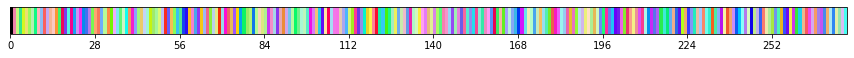

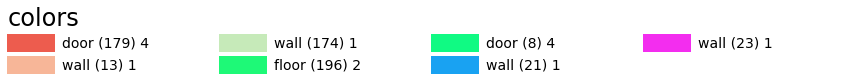

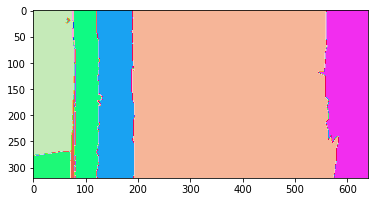

In [21]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapper = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }

goal = mapper[observations['objectgoal'][0]] 
print(goal, index_to_title_map[goal])
    
# semantic_image = prepare_semantic_observation(observations)
semantic_image = observations['semantic']
elements_in_image = []
    
for string in semantic_image:
    for el in string:
        if not(el in elements_in_image):
            elements_in_image.append(el)
                
colors = list(mcolors.CSS4_COLORS.values())
new_colors = colors
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))            
ccmap = matplotlib.cm.get_cmap('jet')   
new_cmap = rand_cmap(len(mapper), type='bright', first_color_black=True, last_color_black=False, verbose=True)
colorss = {}

for i,entry in enumerate(elements_in_image):
    label = index_to_title_map[mapper[entry]] + ' (' + str(entry)+ ') ' + str(mapper[entry])
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=len(mapper))
    
    colorss[label] = new_cmap(norm(entry))
        
plot_colortable(colorss, 'colors')
    
plt.imshow(semantic_image, cmap=new_cmap, vmin=-1, vmax=len(mapper))
plt.show()    

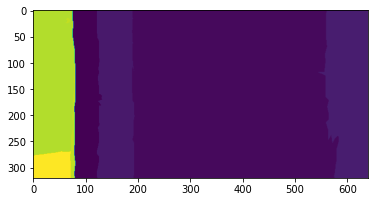

In [22]:
plt.imshow(observations['semantic'])

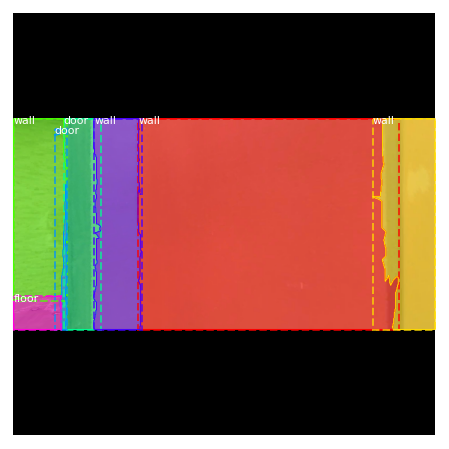

In [23]:
image = observations['rgb']

masks = []
values = []
semantic = observations['semantic']
unique_values = np.unique(semantic)
for value in unique_values:
    obj = (semantic == value)
    
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }
    values.append(instance_id_to_label_id[value])
    
    masks.append(np.array(Image.fromarray(obj)))

values = np.array(values)
masks = np.stack(masks,axis=2)    

original_shape = image.shape
image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)    

mask = utils.resize_mask(masks, scale, padding, crop)
_idx = np.sum(mask, axis=(0, 1)) > 0
mask = mask[:, :, _idx]
bbox = utils.extract_bboxes(mask)

visualize.display_instances(image, bbox, mask, values, 
                            index_to_title_map, figsize=(8, 8))

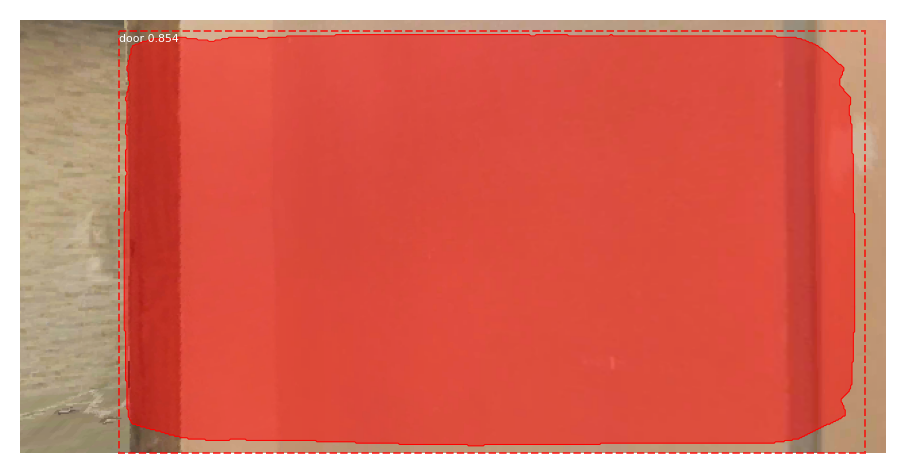

In [24]:
# Visualize results
r = results[1]
visualize.display_instances(observations['rgb'], r['rois'], r['masks'], r['class_ids'], 
                            index_to_title_map, r['scores'])